Simulation of Fire Spreading in a Forest using Von Neumann Neighbourhood and Moore Neighbourhood Algorithms
(Evaluating Sequential and Parallel Implementations)

By Oluwatosin Olubiyi

Initialization of the Forest Grids and General Properties

In [2]:
## assumptions and definitions

EMPTY = 0 # 0 - empty area or cell
TREE = 1 # 1 - cell or area with non burning tree
BTREE = 2 # 2 - cell or area with burning tree\
BORDER = 3 # 3 - border of the forest

probTree = 0.8 # probability of a tree
probBurning = 0.01 # probability of a tree burning
probImmune = 0.3 # probability of a tree to be immune to fire
probLightning = 0.001 # probability of lightning strike

In [3]:
# initializie time at start of simulation

# importing all required libraries

import time
import numpy as np
import matplotlib.pyplot as plt
from random import *
import math
from matplotlib import animation
from copy import deepcopy
import multiprocessing as mp
import numba

initTime = time.perf_counter()
time.sleep(3)
endTime = time.perf_counter()

# difference in time
print("Time Started: {0}, Time Ended: {1}. \nTime Elapsed during the iteration: {2} seconds".format(initTime, endTime, endTime - initTime))

Time Started: 218744.4679028, Time Ended: 218747.4826552. 
Time Elapsed during the iteration: 3.0147523999912664 seconds


Sequential Implementation

In [28]:
# Initialize the forest with non burning trees, empty cells, burning trees and border cells
# - initializing the discrete stochastic system with probTree & probBurning.

def forest_initializer(forest_size):
    # time at start of initialization
    initTime = time.perf_counter()
    
    # initialize the forest with border cells
    forest = BORDER * np.ones((forest_size + 2, forest_size + 2)) 
    
    for i in range(1,forest_size):
        for j in range(1,forest_size):
            if random() < probBurning:
                forest[i][j] = BTREE # there is a burning tree in the cell
            elif random() < probTree:
                forest[i][j] = TREE # there is a non burning tree in the cell
            else:
                forest[i][j] = EMPTY
        
    # time at end of initialization
    endTime = time.perf_counter()
    
    return forest, initTime, endTime

In [5]:
# spreading the fire using the von Neumann neighborhood algorithm

def vnn_fire_spreader(forest, forest_size):
    # time at start of spreading
    initTime = time.perf_counter()
    
    # spreading the fire using von Neumann neighborhood
    for i in range(1, forest_size + 1):
        for j in range(1, forest_size + 1):
            if forest[i][j] == TREE: # if the cell is a tree
                if random() < probImmune: # if the tree is immune to fire
                    forest[i][j] = TREE
                else: # if the tree is not immune to fire
                    if (forest[i - 1][j] == BTREE or forest[i + 1][j] == BTREE or 
                        forest[i][j - 1] == BTREE or forest[i][j + 1] == BTREE): # if the tree is next to a burning tree
                        forest[i - 1][j] = BTREE # the tree burns
                    elif random() < probLightning: # if lightning strikes the site
                        forest[i][j] = BTREE # the tree burns
                    else:
                        forest[i][j] = TREE # the tree is not burned
            elif forest[i][j] == BTREE: # if the cell is a burning tree, then it burns down
                forest[i][j] = EMPTY
            else:  # otherwise the cell is an empty cell
                forest[i][j] = EMPTY # the cell remains empty
    
    # time at end of spreading
    endTime = time.perf_counter()
    
    return forest, initTime, endTime

In [6]:
# spreading the fire using the Moore neighborhood algorithm

def m_fire_spreader(forest, forest_size):
    # time at start of spreading
    initTime = time.perf_counter()
    
    # spreading the fire using Moore neighborhood
    for i in range(1, forest_size + 1):
        for j in range(1, forest_size + 1):
            if forest[i][j] == TREE: # if the cell is a tree
                if random() < probImmune: # if the tree is immune to fire
                    forest[i][j] = TREE
                else: # if the tree is not immune to fire
                    if (forest[i - 1][j] == BTREE or forest[i + 1][j] == BTREE or 
                        forest[i][j - 1] == BTREE or forest[i][j + 1] == BTREE or 
                        forest[i - 1][j - 1] == BTREE or forest[i - 1][j + 1] == BTREE or 
                        forest[i + 1][j - 1] == BTREE or forest[i + 1][j + 1] == BTREE): # if the tree is next to a burning tree
                        forest[i - 1][j] = BTREE # the tree burns
                    elif random() < probLightning: # if lightning strikes the site
                        forest[i][j] = BTREE # the tree burns
                    else:
                        forest[i][j] = TREE # the tree is not burned
            elif forest[i][j] == BTREE: # if the cell is a burning tree, then it burns down
                forest[i][j] = EMPTY
            else:  # otherwise the cell is an empty cell
                forest[i][j] = EMPTY # the cell remains empty
    
    # time at end of spreading
    endTime = time.perf_counter()
    
    return forest, initTime, endTime

Parallel Computing Implementation

In [36]:
# Initialize the forest with non burning trees, empty cells, burning trees and border cells
# - initializing the discrete stochastic system with probTree & probBurning.

@numba.jit(nopython=True, parallel=True)
def parallel_forest_initializer(forest_size):
    # time at start of initialization
    initTime = time.perf_counter()
    
    # initialize the forest with border cells
    forest = BORDER * np.ones((forest_size + 2, forest_size + 2)) 
    
    for i in numba.prange(1, forest_size + 1):
        for j in numba.prange(1, forest_size + 1):
            if random() < probBurning:
                forest[i][j] = BTREE # there is a burning tree in the cell
            elif random() < probTree:
                forest[i][j] = TREE # there is a non burning tree in the cell
            else:
                forest[i][j] = EMPTY
        
    # time at end of initialization
    endTime = time.perf_counter()
    
    return forest, initTime, endTime

In [8]:
# spreading the fire using the von Neumann neighborhood algorithm

@numba.jit(nopython=True, parallel=True)
def parallel_vnn_fire_spreader(forest, forest_size):
    # time at start of spreading
    initTime = time.perf_counter()
    
    # spreading the fire using von Neumann neighborhood
    for i in numba.prange(1, forest_size + 1):
        for j in numba.prange(1, forest_size + 1):
            if forest[i][j] == TREE: # if the cell is a tree
                if random() < probImmune: # if the tree is immune to fire
                    forest[i][j] = TREE
                else: # if the tree is not immune to fire
                    if (forest[i - 1][j] == BTREE or forest[i + 1][j] == BTREE or 
                        forest[i][j - 1] == BTREE or forest[i][j + 1] == BTREE): # if the tree is next to a burning tree
                        forest[i - 1][j] = BTREE # the tree burns
                    elif random() < probLightning: # if lightning strikes the site
                        forest[i][j] = BTREE # the tree burns
                    else:
                        forest[i][j] = TREE # the tree is not burned
            elif forest[i][j] == BTREE: # if the cell is a burning tree, then it burns down
                forest[i][j] = EMPTY
            else:  # otherwise the cell is an empty cell
                forest[i][j] = EMPTY # the cell remains empty
    
    # time at end of spreading
    endTime = time.perf_counter()
    
    return forest, initTime, endTime

In [9]:
# spreading the fire using the Moore neighborhood algorithm

@numba.jit(nopython=True, parallel=True)
def parallel_m_fire_spreader(forest, forest_size):
    # time at start of spreading
    initTime = time.perf_counter()
    
    # spreading the fire using Moore neighborhood
    for i in numba.prange(1, forest_size + 1):
        for j in numba.prange(1, forest_size + 1):
            if forest[i][j] == TREE: # if the cell is a tree
                if random() < probImmune: # if the tree is immune to fire
                    forest[i][j] = TREE
                else: # if the tree is not immune to fire
                    if (forest[i - 1][j] == BTREE or forest[i + 1][j] == BTREE or 
                        forest[i][j - 1] == BTREE or forest[i][j + 1] == BTREE or 
                        forest[i - 1][j - 1] == BTREE or forest[i - 1][j + 1] == BTREE or 
                        forest[i + 1][j - 1] == BTREE or forest[i + 1][j + 1] == BTREE): # if the tree is next to a burning tree
                        forest[i - 1][j] = BTREE # the tree burns
                    elif random() < probLightning: # if lightning strikes the site
                        forest[i][j] = BTREE # the tree burns
                    else:
                        forest[i][j] = TREE # the tree is not burned
            elif forest[i][j] == BTREE: # if the cell is a burning tree, then it burns down
                forest[i][j] = EMPTY
            else:  # otherwise the cell is an empty cell
                forest[i][j] = EMPTY # the cell remains empty
    
    # time at end of spreading
    endTime = time.perf_counter()
    
    return forest, initTime, endTime

Visualization and Animation of the Fire Spread in the Forest

In [29]:
forestGrid100, initTime100, endTime100 = forest_initializer(100)

In [30]:
%matplotlib notebook

In [33]:
# animate the fire spreading with animation

#X_list, Y_list = np.split(forestGrid100, 2, axis=1)
""" X_list, Y_list = [], [] """

""" def animate(i):
    ax.scatter(X_list, Y_list)
    ax = plt.axes(xlim=(0, len(X_list)+1), ylim=(0, len(X_list)+1)) """
#https://stackoverflow.com/questions/23176161/animating-pngs-in-matplotlib-using-artistanimation
    
def visualize_forest(forest, forest_size, fig_no):
    # time at start of visualization
    #initTime = time.perf_counter()
    
    # animate the fire spreading
    fig = plt.figure(fig_no)
    ax = plt.axes(xlim=(0, len(forestGrid100)), ylim=(0, len(forestGrid100)))
    ax.set_aspect('equal')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel('Time: ' + str(round(time.perf_counter() - initTime, 2)) + ' seconds')
    ax.set_ylabel('Time: ' + str(round(time.perf_counter() - initTime, 2)) + ' seconds')
    ax.set_title('Fire Spread')
    ax.grid(True)
    plt.ion()
    
    #myimages = []
    
    for i in range(forest_size + 1):
        for j in range(forest_size + 1):
            if forest[i][j] == TREE:                
                ax.add_patch(plt.Rectangle((i, j), 1, 1, color='green'))
            elif forest[i][j] == BTREE:
                ax.add_patch(plt.Rectangle((i, j), 1, 1, color='red'))
            elif forest[i][j] == EMPTY:
                ax.add_patch(plt.Rectangle((i, j), 1, 1, color='white'))
            else:
                ax.add_patch(plt.Rectangle((i, j), 1, 1, color='black'))
        
    imgplot = ax.imshow(forest)

    #anim = animation.ArtistAnimation(fig, myimages, interval=50, blit=True, repeat_delay=1000)
    #(fig, animate, frames=range(forest_size + 2), interval=forest_size)        
    plt.show()
    
    # plt.pause(0.001)
    
    # time at end of visualization
    #endTime = time.perf_counter()
    
    #return initTime, endTime

<IPython.core.display.Javascript object>


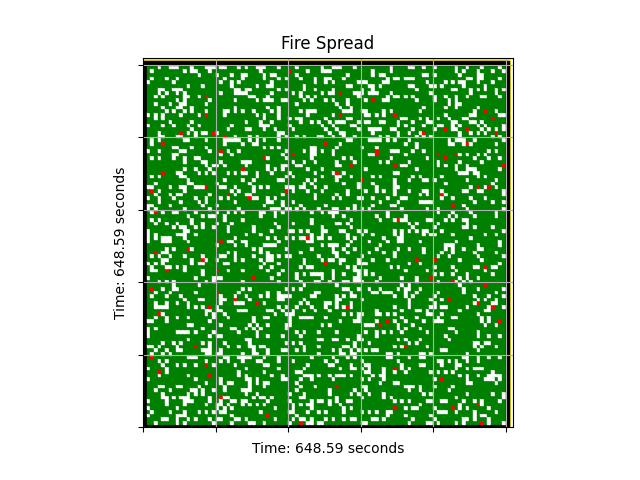

In [35]:
visualize_forest(forestGrid100, 100, 1)

<IPython.core.display.Javascript object>


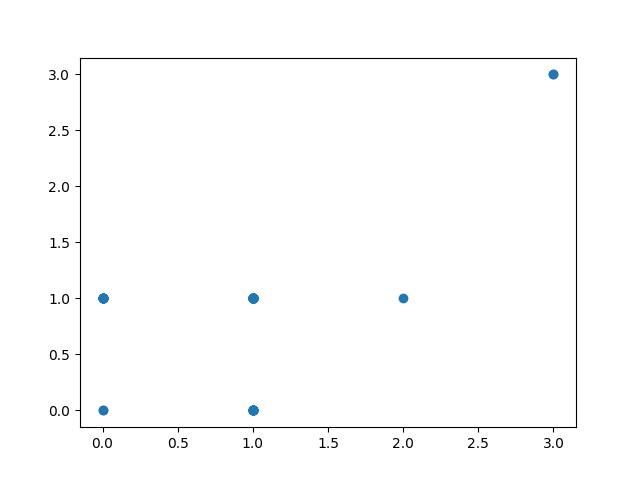

In [24]:
fig = plt.figure(2)
plt.scatter(forestGrid100[:, 0], forestGrid100[:, 1], cmap='hot')

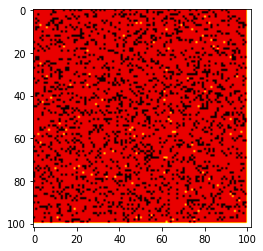

In [17]:
%matplotlib inline
plt.figure(3)
plt.imshow(forestGrid100, cmap='hot')